In [118]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import numpy as np
from rasterio.plot import reshape_as_raster, reshape_as_image
import pickle
from empatches import EMPatches

In [62]:
overlap = 0.85

## Loading Data

In [63]:
nm_shp = gpd.read_file("JamaicaNonmangroveLabels.shp")
m_shp = gpd.read_file("JamaicaMangroveLabelsFixed.shp")

nm_geoms = nm_shp.geometry
m_geoms = m_shp.geometry

In [64]:
src = rasterio.open("JamaicaFeaturesNoSAR.tif")
mask_src = rasterio.open("JamaicaImageMask.tif")

In [65]:
m_image, m_transform = mask(src, m_geoms, crop = False, nodata = 0)
nm_image, nm_transform = mask(src, nm_geoms, crop = False, nodata = 0)

#Getting mask for each class
mmask, mmask_transform = mask(mask_src, m_geoms, crop = False, nodata = 0)
nmmask, nmmask_transform = mask(mask_src, nm_geoms, crop = False, nodata = 0)

#Getting pixels with valid labels (XOR mangrove or nonmangrove)
#Both 0: unlabeled pixel - NOT VALID
#Both 1: pixel with overlapping label - NOT VALID

valid_mask = (nmmask != mmask)

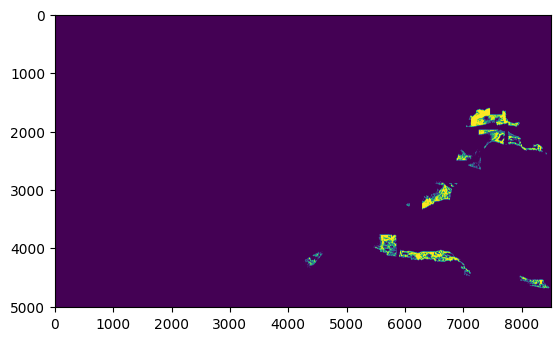

<Axes: >

In [66]:
from rasterio.plot import show
show(mmask)

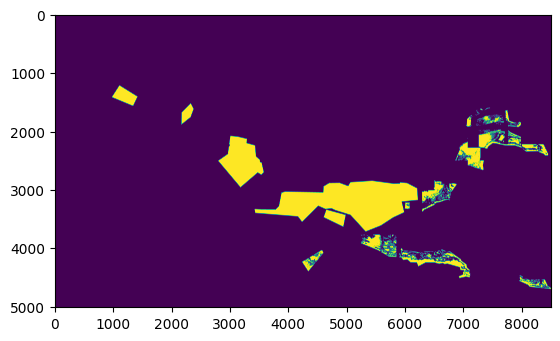

<Axes: >

In [67]:
show(nmmask)

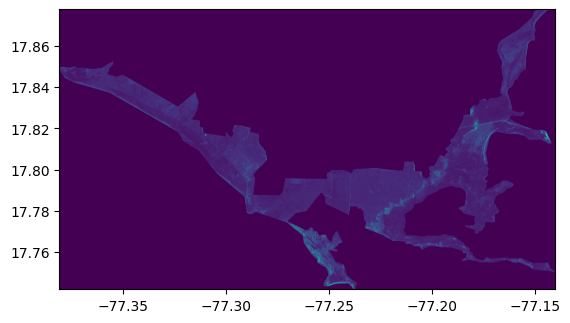

<Axes: >

In [68]:
show(src)

In [69]:
def get_valid_tiles(valid_mask, indices, valid_ratio = 0.9):
    """
    From a mask containing a record of valid labels, get indices from patches where 
    """
    mask = reshape_as_image(valid_mask)
    valid_tiles = []
    
    for i, patch in enumerate(indices):
        tile = mask[patch[0]:patch[1], patch[2]:patch[3], :]
        # If the total amount of valid pixels equals a percentage the size of the patch, mark it as valud
        if (np.sum(tile) > ((patch[1] - patch[0]) * (patch[3] - patch[2])) * valid_ratio):
            valid_tiles.append(i)
                               
    print("{} valid patches".format(len(valid_tiles)))
    return valid_tiles

# 256 Tile Size Dataset

In [119]:
emp = EMPatches()
img_patches, img_indices = emp.extract_patches(reshape_as_image(src.read()), patchsize = 256, overlap = 0.85)
label_patches, label_indices = emp.extract_patches(reshape_as_image(mmask), patchsize = 256, overlap = 0.85)

In [120]:
valid_tiles = get_valid_tiles(valid_mask, img_indices)

images = [img_patches[i] for i in valid_tiles]
labels = [label_patches[i] for i in valid_tiles]

570 valid patches


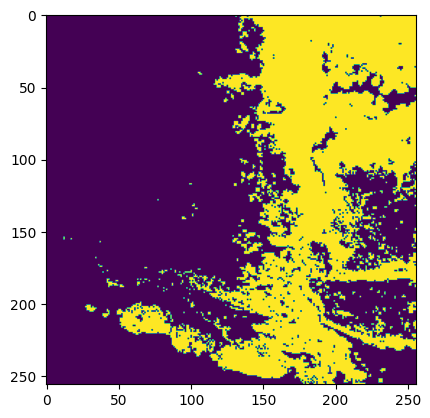

<Axes: >

In [121]:
show(reshape_as_raster(labels[440]))

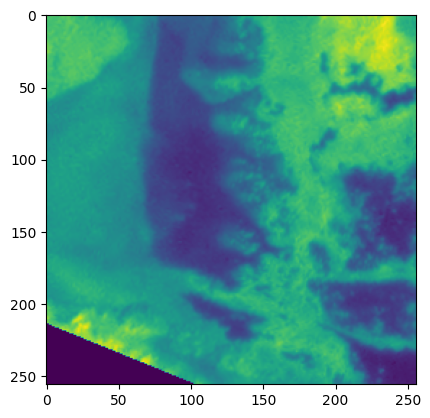

<Axes: >

In [122]:
show(reshape_as_raster(images[440])[7,:,:])

In [123]:
# Getting total number of tiles with mangrove labels

m_tiles = []
for i, tile in enumerate(labels):
    #If the label tile has any mangrove, the sum of unique values should be 1
    if sum(np.unique(tile)) == 1:  
        m_tiles.append(i)
print(m_tiles)

[440, 454, 455, 468, 469, 481, 482, 483, 495, 496, 497, 536, 537, 541, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569]


In [124]:
# Saving datasets as pickle

with open('256px_images.pkl', 'wb') as handle:
    pickle.dump(images, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('256px_labels.pkl', 'wb') as handle:
    pickle.dump(labels, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('256_mlabels.pkl', 'wb') as handle:
    pickle.dump(m_tiles, handle, protocol=pickle.HIGHEST_PROTOCOL)

# 128 Tile Size Dataset

In [125]:
from empatches import EMPatches

emp = EMPatches()
img_patches, img_indices = emp.extract_patches(reshape_as_image(src.read()), patchsize = 128, overlap = 0.85)
label_patches, label_indices = emp.extract_patches(reshape_as_image(mmask), patchsize = 128, overlap = 0.85)

In [126]:
valid_tiles = get_valid_tiles(valid_mask, img_indices)

images = [img_patches[i] for i in valid_tiles]
labels = [label_patches[i] for i in valid_tiles]

4092 valid patches


In [127]:
# Getting total number of tiles with mangrove labels

m_tiles = []
for i, tile in enumerate(labels):
    #If the label tile has any mangrove, the sum of unique values should be 1
    if sum(np.unique(tile)) == 1:  
        m_tiles.append(i)
print(len(m_tiles))

1050


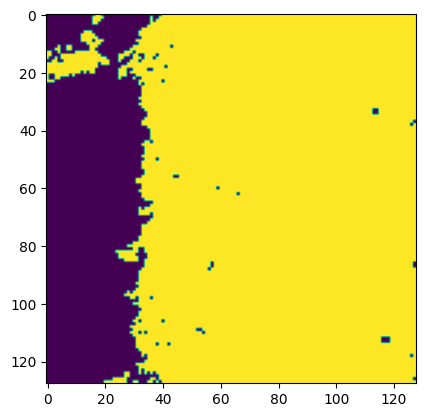

<Axes: >

In [128]:
show(reshape_as_raster(labels[3700]))

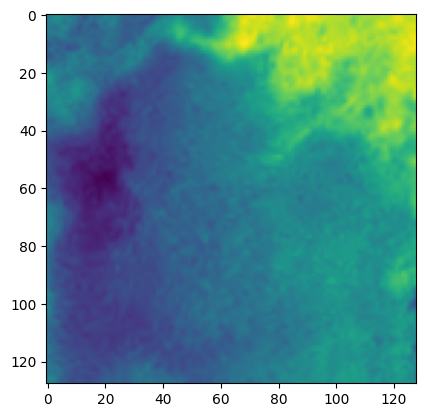

<Axes: >

In [129]:
show(reshape_as_raster(images[3700])[7,:,:])

In [130]:
# Saving datasets as pickle

with open('128px_images.pkl', 'wb') as handle:
    pickle.dump(images, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('128px_labels.pkl', 'wb') as handle:
    pickle.dump(labels, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('128_mlabels.pkl', 'wb') as handle:
    pickle.dump(m_tiles, handle, protocol=pickle.HIGHEST_PROTOCOL)